Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB
None

Dataset Description:
        model_year
count  4009.000000
mean   2015.515590
std       6.104816
min    1974.000000
25%    2012.000000
50%    2017.000000
75%    2020.000000
max    2024.000000


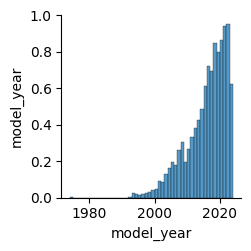

Linear Regression (Scikit-learn) - MSE: 14101050931.496511, R2 Score: 0.03706277036549854
Ridge Regression - MSE: 13852563138.015165, R2 Score: 0.05403158698883681
Lasso Regression - MSE: 13853951301.027388, R2 Score: 0.0539367916539526
Linear Regression (Scratch) - MSE: 14093282689.157993, R2 Score: 0.037593250667493194

Best Model: Ridge Regression
Best Hyperparameter: {'alpha': 0.1}

Selected Features (Indices): [   0    1    2 ... 4375 4376 4383]

Final Model - MSE: 13718234886.647682, R2 Score: 0.06320463904444873


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel

# Load Dataset
df = pd.read_csv("/content/drive/MyDrive/Concept and Technologies of AI/used_cars.csv")

# Exploratory Data Analysis (EDA)
print("Dataset Info:")
print(df.info())
print("\nDataset Description:")
print(df.describe())
sns.pairplot(df)
plt.show()

# Data Preprocessing
# Handling missing values (if any)
df = df.dropna()

# Convert 'price' column to numeric after removing '$' and ','
df.loc[:, 'price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Selecting Features and Target
X = df.drop(columns=['price'])  # Assuming 'price' is the target variable
y = df['price']

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Apply OneHotEncoding to categorical variables and StandardScaler to numerical features
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transform training and testing data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Linear Regression from Scratch with Regularization (Ridge-like)
class LinearRegressionFromScratch:
    def __init__(self, regularization=1e-5):  # Small regularization term to handle singularity
        self.weights = None
        self.regularization = regularization

    def fit(self, X, y):
        # Add intercept
        X = np.c_[np.ones(X.shape[0]), X]
        # Compute weights using the regularized normal equation
        identity = np.eye(X.shape[1])
        identity[0, 0] = 0  # Do not regularize the intercept term
        self.weights = np.linalg.inv(X.T @ X + self.regularization * identity) @ X.T @ y

    def predict(self, X):
        # Add intercept
        X = np.c_[np.ones(X.shape[0]), X]
        return X @ self.weights

# Build Models
model1 = LinearRegression()  # Scikit-learn Linear Regression
model2 = Ridge()             # Ridge Regression
model3 = Lasso()             # Lasso Regression
model4 = LinearRegressionFromScratch()  # Linear Regression from scratch

# Train and Evaluate Models
models = {
    "Linear Regression (Scikit-learn)": model1,
    "Ridge Regression": model2,
    "Lasso Regression": model3,
    "Linear Regression (Scratch)": model4
}
results = {}

for name, model in models.items():
    if name == "Linear Regression (Scratch)":
        model.fit(X_train.toarray(), y_train)  # Convert sparse matrix to dense
        y_pred = model.predict(X_test.toarray())
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R2 Score': r2}
    print(f"{name} - MSE: {mse}, R2 Score: {r2}")

# Select the best model
best_model_name = max(results, key=lambda k: results[k]['R2 Score'])
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name}")

# Hyperparameter Optimization (for Ridge and Lasso only)
if best_model_name in ["Ridge Regression", "Lasso Regression"]:
    param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
    grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print(f"Best Hyperparameter: {best_params}")
    best_model.set_params(**best_params)
    best_model.fit(X_train, y_train)

# Feature Selection
selector = SelectFromModel(best_model, threshold='mean', prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

selected_features = selector.get_support(indices=True)
print(f"\nSelected Features (Indices): {selected_features}")

# Rebuild Model with Best Hyperparameters and Selected Features
final_model = type(best_model)(**(best_model.get_params()))
final_model.fit(X_train_selected, y_train)
y_final_pred = final_model.predict(X_test_selected)

# Final Model Evaluation
final_mse = mean_squared_error(y_test, y_final_pred)
final_r2 = r2_score(y_test, y_final_pred)
print(f"\nFinal Model - MSE: {final_mse}, R2 Score: {final_r2}")



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
